In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import load_img
import os
import random
import gc
from PIL import Image, ImageFont
import visualkeras
%config Completer.use_jedi = False

### Some useful functions

In [2]:
def get_rand_pic():
    file = random.choice(os.listdir("./test_data/"))
    rand_obj = keras.preprocessing.image.load_img('./test_data/{}'.format(file), target_size=(224,224))
    return rand_obj

In [3]:
def recognize(pic, data, mod):
    '''pic is a Image, data is keras DirectoryIterator.#
    Returns the name (string) of category recognized'''
    np_pic = np.array(pic)
    batch_pic = np.expand_dims(np_pic, axis=0)
    processed_pic = keras.applications.mobilenet_v2.preprocess_input(batch_pic)
    #print(data.class_indices)   
    argmax = np.argmax(mod.predict(processed_pic))
    dicData = data.class_indices
    keys = list(dicData.keys())
    vals = list(dicData.values())
    pred_obj = keys[vals.index(argmax)]
    pred_obj = pred_obj.upper()
    print('Predicted object: ')
    return pred_obj, pic
    

In [4]:
def plot_loss_and_acc(hist):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    hist_df = pd.DataFrame(hist.history)
    val_cat_acc = list(hist.history.keys())[3]
    val_loss = list(hist.history.keys())[2]
    ax[0].plot(hist_df[val_cat_acc])
    ax[1].plot(hist_df[val_loss])
    ax[0].set_title('validation accuracy')
    ax[1].set_title('validation loss')
    ax[0].set_xlabel('epochs')
    ax[1].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[1].set_ylabel('loss')
#pd.DataFrame(history.history['accuracy']).plot()

In [5]:
def plot_all(hists):
    '''hists is a list of Keras History objs.
    Returns two graphs with acc and loss'''
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    for hist in hists:
        hist_df = pd.DataFrame(hist[0].history)
        val_cat_acc = list(hist[0].history.keys())[3]
        val_loss = list(hist[0].history.keys())[2]
        ax[0].plot(hist_df[val_cat_acc])
        ax[1].plot(hist_df[val_loss], label=hist[1])
    #ax[0].set_title('Accuracy on validation data', fontsize=16)
    #ax[1].set_title('Loss on validation data', fontsize=16)
    ax[0].set_xlabel('epochs', fontsize=16)
    ax[1].set_xlabel('epochs', fontsize=16)
    ax[0].set_ylabel('accuracy', fontsize=16)
    ax[1].set_ylabel('loss', fontsize=16)
    handles, labels = ax[1].get_legend_handles_labels()
    print(handles)
    print(labels)
    st = fig.suptitle("Comparison between models on validation data", fontsize=18)
    st.set_y(0.95)
    plt.figlegend(loc = 'lower center', borderaxespad=0.1, ncol=2, labelspacing=0.,  prop={'size': 13} )
    fig.savefig("./images/model_comparison.png")
#pd.DataFrame(history.history['accuracy']).plot()

#### Scheduler function for adaptive learning rate

In [6]:
#Define scheduler for adaptive learning rate
def lr_exp_decay(epoch):
   '''lr is the initial leaning rate (float).
       epoch is the number of epochs (int).
       Returns  a new lr'''
   lr = 0.0001
   k = 0.1
   lrate = lr * np.exp(-k*epoch)
   return lrate

#### Global

In [7]:
hists = []

### Preprocessing

In [8]:
prep = keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=keras.applications.mobilenet_v2.preprocess_input)

In [9]:
# here we create a generator function , that will reads the images from 
# our harddrive
data = prep.flow_from_directory(
                    directory='./data',
                    class_mode='categorical',
                    classes=os.listdir('./data'),
                    batch_size=1458,
                    target_size=(224, 224)
)

Found 1355 images belonging to 7 classes.


In [10]:
type(data)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [11]:
data.class_indices

{'apple': 0,
 'knife': 1,
 'locher': 2,
 'orange': 3,
 'pencil': 4,
 'pumpkin': 5,
 'tomato': 6}

In [12]:
# mix values in data
random.shuffle(data)

In [13]:
xtrain, ytrain = next(data)

In [14]:
xtrain.shape, ytrain.shape

((1355, 224, 224, 3), (1355, 7))

In [15]:

print(xtrain.shape)
print(ytrain.shape)

(1355, 224, 224, 3)
(1355, 7)


In [16]:
### font for architecture visualization
font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!

### Define the model

#### Some collback functions used

In [17]:
cb_LRS = keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=0)
cb_ES = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3)

####  Logistic Regression

In [18]:
m_LR = keras.models.Sequential(name='RELOG')
m_LR.add(keras.layers.Flatten())
m_LR.add(keras.layers.Dense(units=7, 
                             activation='sigmoid',
                             input_shape=(224, 224, 3)))

In [19]:
# For a multi-class classification problem use categorical crossentropy
m_LR.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss=keras.losses.categorical_crossentropy,
              metrics=['categorical_accuracy'])

In [20]:
history = m_LR.fit(xtrain, ytrain, 
                    epochs=50,
                    batch_size=128, 
                    callbacks = [cb_ES],
                    verbose=2, 
                    validation_split=0.2  # use 10% of the data for validation
)

Epoch 1/50
9/9 - 2s - loss: 1.7558 - categorical_accuracy: 0.3173 - val_loss: 1.6504 - val_categorical_accuracy: 0.3653
Epoch 2/50
9/9 - 1s - loss: 1.4119 - categorical_accuracy: 0.4751 - val_loss: 1.3900 - val_categorical_accuracy: 0.4834
Epoch 3/50
9/9 - 1s - loss: 1.2245 - categorical_accuracy: 0.5738 - val_loss: 1.2463 - val_categorical_accuracy: 0.5535
Epoch 4/50
9/9 - 1s - loss: 1.1018 - categorical_accuracy: 0.6292 - val_loss: 1.1592 - val_categorical_accuracy: 0.6125
Epoch 5/50
9/9 - 1s - loss: 1.0015 - categorical_accuracy: 0.6734 - val_loss: 1.0856 - val_categorical_accuracy: 0.6605
Epoch 6/50
9/9 - 1s - loss: 0.9352 - categorical_accuracy: 0.7048 - val_loss: 1.0483 - val_categorical_accuracy: 0.6605
Epoch 7/50
9/9 - 1s - loss: 0.8790 - categorical_accuracy: 0.7352 - val_loss: 1.0143 - val_categorical_accuracy: 0.6753
Epoch 8/50
9/9 - 1s - loss: 0.8303 - categorical_accuracy: 0.7601 - val_loss: 0.9797 - val_categorical_accuracy: 0.7085
Epoch 9/50
9/9 - 1s - loss: 0.7880 - cat

In [21]:
#saving the model
m_LR.save('./models/LogisticReg_model.h5')

In [22]:
hists.append((history, m_LR.name))

In [23]:
m_LR.summary()

Model: "RELOG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 7)                 1053703   
Total params: 1,053,703
Trainable params: 1,053,703
Non-trainable params: 0
_________________________________________________________________


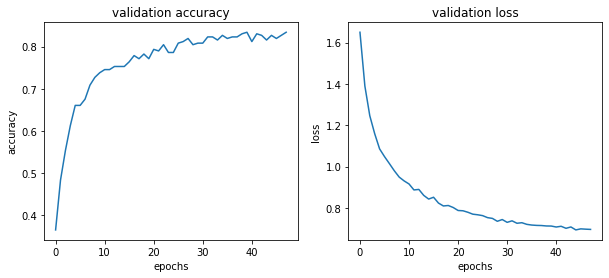

In [24]:
plot_loss_and_acc(history)

#### RELOG: Test with external picture

In [25]:
rand_obj = get_rand_pic()
#rand_obj

Predicted object: 
ORANGE


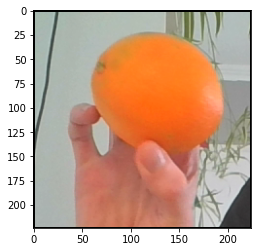

In [26]:
pred_obj, true_obj = recognize(rand_obj, data, m_LR)
print(pred_obj)
plt.imshow(true_obj)

### ANN with dense layers

In [27]:
# initialize model
m_D = keras.models.Sequential(name='DENSE')

# input layer, also flattens input
m_D.add(keras.layers.Flatten(input_shape=(224, 224, 3)))

# dense layer hidden_1
m_D.add(keras.layers.Dense(
                        units = 256,
                        name = 'Hidden_1'))
m_D.add(keras.layers.BatchNormalization())
m_D.add(keras.layers.LeakyReLU())


#one layer dropout
m_D.add(keras.layers.Dropout(0.2))

#dense layer hidden_2
m_D.add(keras.layers.Dense(
                        units = 128,
                        name = 'Hidden_2'))
m_D.add(keras.layers.BatchNormalization())
m_D.add(keras.layers.LeakyReLU())

#one layer dropout
m_D.add(keras.layers.Dropout(0.2))


#dense layer hidden_3
m_D.add(keras.layers.Dense(
                        units = 64,
                        name = 'Hidden_3'))
m_D.add(keras.layers.BatchNormalization())
m_D.add(keras.layers.LeakyReLU())


#output layer
m_D.add(
    keras.layers.Dense(
        units=7, 
        activation=keras.activations.softmax, #sigmoid can be use but softmax gives a results that sums to 100!
        name='output'))



In [28]:
m_D.summary()

Model: "DENSE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
Hidden_1 (Dense)             (None, 256)               38535424  
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
Hidden_2 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512   

In [29]:
# compile
m_D.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=['categorical_accuracy'])

In [30]:
history = m_D.fit(xtrain, ytrain, 
                    epochs=40,
                    batch_size=128, 
                    callbacks=[cb_ES],
                    verbose=2, 
                    validation_split=0.2  # use 20% of the data for validation
)

Epoch 1/40
9/9 - 5s - loss: 1.6729 - categorical_accuracy: 0.3958 - val_loss: 3.7718 - val_categorical_accuracy: 0.5166
Epoch 2/40
9/9 - 4s - loss: 1.1541 - categorical_accuracy: 0.6042 - val_loss: 2.8487 - val_categorical_accuracy: 0.4834
Epoch 3/40
9/9 - 4s - loss: 0.9729 - categorical_accuracy: 0.6900 - val_loss: 2.1521 - val_categorical_accuracy: 0.5830
Epoch 4/40
9/9 - 4s - loss: 0.8606 - categorical_accuracy: 0.7315 - val_loss: 1.7297 - val_categorical_accuracy: 0.5756
Epoch 5/40
9/9 - 4s - loss: 0.7581 - categorical_accuracy: 0.7638 - val_loss: 1.4757 - val_categorical_accuracy: 0.6162
Epoch 6/40
9/9 - 4s - loss: 0.6729 - categorical_accuracy: 0.7814 - val_loss: 1.2857 - val_categorical_accuracy: 0.5793
Epoch 7/40
9/9 - 4s - loss: 0.5880 - categorical_accuracy: 0.8183 - val_loss: 1.1092 - val_categorical_accuracy: 0.6273
Epoch 8/40
9/9 - 4s - loss: 0.5335 - categorical_accuracy: 0.8367 - val_loss: 0.9461 - val_categorical_accuracy: 0.7380
Epoch 9/40
9/9 - 4s - loss: 0.4622 - cat

In [31]:
#saving the model
m_D.save('./models/dense_model.h5')

In [32]:
hists.append((history, m_D.name))

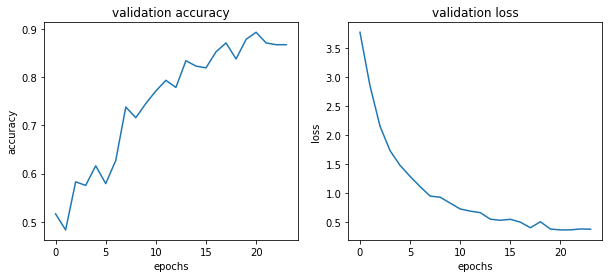

In [33]:
plot_loss_and_acc(history)

### ANN DENSE: testing external data

In [34]:
rand_obj = get_rand_pic()
#rand_obj

Predicted object: 
TOMATO


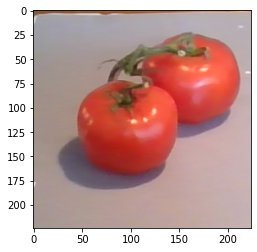

In [35]:
pred_obj, true_obj = recognize(rand_obj, data, m_D)
print(pred_obj)
plt.imshow(true_obj)

## ANN using Covolution

In [36]:
m_CNN = keras.models.Sequential(name='CNN')

m_CNN.add(keras.layers.Conv2D(filters=64, 
                              padding='same',
                              kernel_size=(3, 3), 
                              input_shape=(224, 224, 3)))

m_CNN.add(keras.layers.MaxPool2D())

m_CNN.add(keras.layers.Conv2D(filters=16, 
                              padding='same',
                              kernel_size=(3, 3)
                             ))

#model.add(keras.layers.Conv2D(filters=64, 
#                              padding='same',
#                              kernel_size=(3, 3)
#                             ))

m_CNN.add(keras.layers.MaxPool2D())

m_CNN.add(keras.layers.Conv2D(filters=32, 
                              padding='same',
                              kernel_size=(3, 3)
                             ))

m_CNN.add(keras.layers.MaxPool2D())

#model.add(keras.layers.Conv2D(filters=256, 
#                              padding='same',
#                              kernel_size=(3, 3)
#                             ))

#model.add(keras.layers.MaxPool2D())

#model.add(keras.layers.Conv2D(filters=512, 
#                              padding='same',
#                              kernel_size=(3, 3)
#                             ))

m_CNN.add(keras.layers.Flatten())

m_CNN.add(keras.layers.Dense(units = 16))
m_CNN.add(keras.layers.BatchNormalization())
m_CNN.add(keras.layers.LeakyReLU())

#model.add(keras.layers.Dropout(0.2))

m_CNN.add(keras.layers.Dense(units=7, activation='softmax'))

In [37]:
m_CNN.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      9232      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0       

In [38]:
# compile
m_CNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.categorical_crossentropy,
              metrics=['categorical_accuracy'])

In [39]:
history = m_CNN.fit(xtrain, ytrain, 
                    epochs=20,
                    batch_size=128, 
                    verbose=2, 
                    callbacks=[cb_ES],
                    validation_split=0.2  # use 10% of the data for validation
)

Epoch 1/20
9/9 - 76s - loss: 1.5609 - categorical_accuracy: 0.4354 - val_loss: 1.6707 - val_categorical_accuracy: 0.4797
Epoch 2/20
9/9 - 72s - loss: 1.1815 - categorical_accuracy: 0.6116 - val_loss: 1.5889 - val_categorical_accuracy: 0.5756
Epoch 3/20
9/9 - 72s - loss: 1.0298 - categorical_accuracy: 0.7140 - val_loss: 1.5437 - val_categorical_accuracy: 0.5609
Epoch 4/20
9/9 - 72s - loss: 0.9267 - categorical_accuracy: 0.7804 - val_loss: 1.5350 - val_categorical_accuracy: 0.5609
Epoch 5/20
9/9 - 73s - loss: 0.8648 - categorical_accuracy: 0.8054 - val_loss: 1.5471 - val_categorical_accuracy: 0.5941
Epoch 6/20
9/9 - 72s - loss: 0.8027 - categorical_accuracy: 0.8386 - val_loss: 1.5384 - val_categorical_accuracy: 0.6568
Epoch 7/20
9/9 - 76s - loss: 0.7502 - categorical_accuracy: 0.8681 - val_loss: 1.5183 - val_categorical_accuracy: 0.7454
Epoch 8/20
9/9 - 73s - loss: 0.7051 - categorical_accuracy: 0.8985 - val_loss: 1.5228 - val_categorical_accuracy: 0.7565
Epoch 9/20
9/9 - 72s - loss: 0.6

In [40]:
#saving the model
m_CNN.save('./models/CNN_model.h5')

In [41]:
hists.append((history, m_CNN.name))

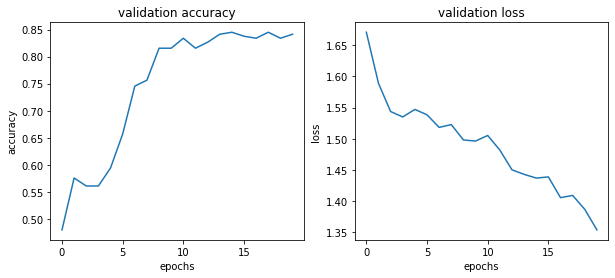

In [42]:
plot_loss_and_acc(history)

### ANN COVOLUTIONAL: testing external data

In [43]:
rand_obj = get_rand_pic()
#rand_obj

Predicted object: 
PENCIL


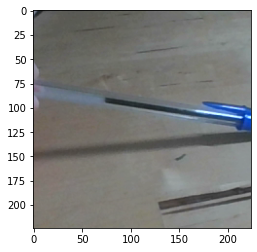

In [44]:
pred_obj, true_obj = recognize(rand_obj, data, m_CNN)
print(pred_obj)
plt.imshow(true_obj)

## Trained convolutional base + dense

In [45]:
prep = keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=keras.applications.mobilenet_v2.preprocess_input)

In [46]:
data = prep.flow_from_directory(
                    directory='./data',
                    class_mode='categorical',
                    classes=os.listdir('./data'),
                    batch_size=1458,
                    target_size=(224, 224)
)

Found 1355 images belonging to 7 classes.


In [47]:
# mix values in data
random.shuffle(data)

In [48]:
xtrain, ytrain = next(data)

In [49]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
            weights='imagenet',
            alpha=0.35, #parameter specific to this model it reduces the number of overal weights
            pooling='avg', # like flattering at last layer
            include_top=False, #we only want base not final dense
            input_shape=(224,224,3))

#Freeze the base model's weights
base_model.trainable=False

In [50]:
#base_model.summary()

In [51]:
m_BD = keras.Sequential(name='BASE_DENSE')
m_BD.add(base_model)
m_BD.add(keras.layers.Dense(
                        units=16,
                        activation='relu'))
m_BD.add(keras.layers.Dropout(0.1))
m_BD.add(keras.layers.Dense(
                        units=7,
                        activation='softmax'))

In [52]:
m_BD.summary()

Model: "BASE_DENSE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.35_224 (Functi (None, 1280)              410208    
_________________________________________________________________
dense_3 (Dense)              (None, 16)                20496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 119       
Total params: 430,823
Trainable params: 20,615
Non-trainable params: 410,208
_________________________________________________________________


In [53]:
m_BD.compile(
        #optimizer=keras.optimizers.Adam(),
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy])

In [54]:
hist = m_BD.fit(
                xtrain,
                ytrain,
                epochs = 50,
                verbose=2,
                batch_size=128,
                callbacks=[cb_ES],
                validation_split=0.2)

Epoch 1/50
9/9 - 17s - loss: 1.3770 - categorical_accuracy: 0.4769 - val_loss: 0.9692 - val_categorical_accuracy: 0.6494
Epoch 2/50
9/9 - 14s - loss: 0.8151 - categorical_accuracy: 0.6882 - val_loss: 0.6863 - val_categorical_accuracy: 0.7749
Epoch 3/50
9/9 - 14s - loss: 0.6198 - categorical_accuracy: 0.7943 - val_loss: 0.5178 - val_categorical_accuracy: 0.8561
Epoch 4/50
9/9 - 15s - loss: 0.4803 - categorical_accuracy: 0.8616 - val_loss: 0.3916 - val_categorical_accuracy: 0.9041
Epoch 5/50
9/9 - 15s - loss: 0.3609 - categorical_accuracy: 0.8967 - val_loss: 0.2844 - val_categorical_accuracy: 0.9262
Epoch 6/50
9/9 - 15s - loss: 0.2945 - categorical_accuracy: 0.9188 - val_loss: 0.2561 - val_categorical_accuracy: 0.9299
Epoch 7/50
9/9 - 15s - loss: 0.2509 - categorical_accuracy: 0.9253 - val_loss: 0.2034 - val_categorical_accuracy: 0.9483
Epoch 8/50
9/9 - 15s - loss: 0.1972 - categorical_accuracy: 0.9483 - val_loss: 0.1730 - val_categorical_accuracy: 0.9483
Epoch 9/50
9/9 - 15s - loss: 0.1

In [55]:
#saving the model
m_BD.save('./models/BaseDense_model.h5')

In [56]:
hists.append((hist, m_BD.name))

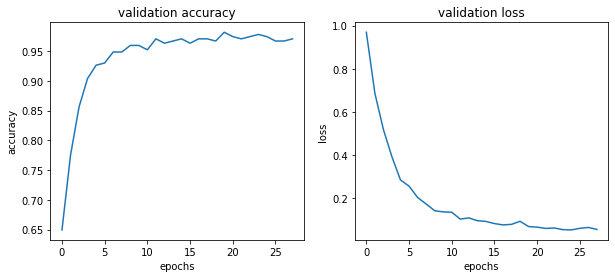

In [57]:
plot_loss_and_acc(hist)

In [58]:
### BASE + DENSE: Test with external data

In [59]:
rand_obj = get_rand_pic()
#rand_obj

Predicted object: 
PENCIL


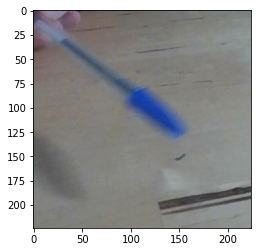

In [60]:
pred_obj, true_obj = recognize(rand_obj, data, m_BD)
print(pred_obj)
plt.imshow(true_obj)

[<matplotlib.lines.Line2D object at 0x7fcb43532f60>, <matplotlib.lines.Line2D object at 0x7fcb43540518>, <matplotlib.lines.Line2D object at 0x7fcb43540a90>, <matplotlib.lines.Line2D object at 0x7fcb434cf080>]
['RELOG', 'DENSE', 'CNN', 'BASE_DENSE']


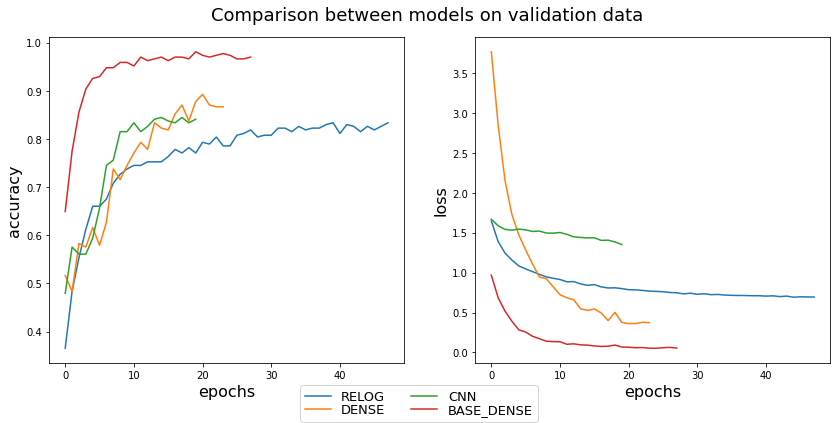

In [61]:
plot_all(hists)